In [1]:
!pip install -q transformers datasets xmltodict scikit-learn

import os
import xmltodict
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from datasets import Dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt


#ATSA on MAMS with RoBERTa:

In [2]:
!pip install transformers datasets lxml -q

import os
import xml.etree.ElementTree as ET
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report

#Parse XML to extract (sentence, aspect_term, polarity) triples

In [3]:
def parse_atsa_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []

    for sentence in root.findall(".//sentence"):
        text = sentence.find("text").text
        aspectTerms = sentence.find("aspectTerms")
        if aspectTerms is not None:
            for aspect in aspectTerms.findall("aspectTerm"):
                term = aspect.attrib['term']
                polarity = aspect.attrib['polarity']
                data.append((text, term, polarity))

    return pd.DataFrame(data, columns=["sentence", "aspect_term", "label"])


# Load datasets (provide correct paths to your train, val, and test ATSA XML files)
train_df = parse_atsa_xml("/content/train ATSA.xml")
val_df = parse_atsa_xml("/content/val ATSA.xml")
test_df = parse_atsa_xml("/content/test ATSA.xml")

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df.head())


Train: 11186 Val: 1332 Test: 1336
                                            sentence aspect_term     label
0  The decor is not special at all but their food...       decor  negative
1  The decor is not special at all but their food...        food  positive
2  The decor is not special at all but their food...      prices  positive
3  when tables opened up, the manager sat another...      tables   neutral
4  when tables opened up, the manager sat another...     manager  negative


#Encode labels

In [5]:
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])
val_df["label"] = label_encoder.transform(val_df["label"])
test_df["label"] = label_encoder.transform(test_df["label"])

In [6]:
print("\nLabel Distribution in Test Set (%):")
label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}
label_percentages = test_df['label'].map(label_map_rev).value_counts(normalize=True) * 100
print(label_percentages.round(2).astype(str) + '%')


Label Distribution in Test Set (%):
label
negative    45.43%
neutral     29.94%
positive    24.63%
Name: proportion, dtype: object


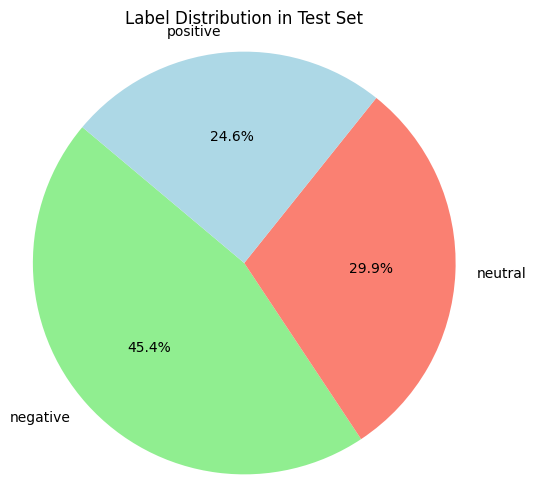

In [7]:
import matplotlib.pyplot as plt

# Mapping and percentage
label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}
label_percentages = test_df['label'].map(label_map_rev).value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    label_percentages,
    labels=label_percentages.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['lightgreen', 'salmon', 'lightblue']
)
plt.title('Label Distribution in Test Set')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()


In [ ]:
# Check what the actual column names are
print(train_df.columns.tolist())


['sentence', 'aspect_term', 'label']


#Load tokenizer and tokenize inputs

In [ ]:
model_name = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

train_dataset = Dataset.from_pandas(train_df[["sentence", "aspect_term", "label"]])
val_dataset = Dataset.from_pandas(val_df[["sentence", "aspect_term", "label"]])
test_dataset = Dataset.from_pandas(test_df[["sentence", "aspect_term", "label"]])

def tokenize_function(example):
    return tokenizer(
        example["sentence"] + " [ASP] " + example["aspect_term"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_train = train_dataset.map(tokenize_function, batched=False)
tokenized_val = val_dataset.map(tokenize_function, batched=False)
tokenized_test = test_dataset.map(tokenize_function, batched=False)

Map:   0%|          | 0/11186 [00:00<?, ? examples/s]

Map:   0%|          | 0/1332 [00:00<?, ? examples/s]

Map:   0%|          | 0/1336 [00:00<?, ? examples/s]

#Format datasets for PyTorch

In [ ]:
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

#Load model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Model Training

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/atsa-roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="/content/logs",
    logging_steps=10,
    save_total_limit=1,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    report = classification_report(labels, predictions, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1_positive": report["2"]["f1-score"],
        "f1_negative": report["0"]["f1-score"],
        "f1_neutral": report["1"]["f1-score"],
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-22-ff1c74e042fb>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Positive,F1 Negative,F1 Neutral
1,0.340600,0.551678,0.808559,0.787286,0.800609,0.827586
2,0.353500,0.506672,0.823574,0.807931,0.813609,0.839966
3,0.368000,0.592342,0.822072,0.808203,0.805471,0.841121


TrainOutput(global_step=2100, training_loss=0.4287283953030904, metrics={'train_runtime': 798.3795, 'train_samples_per_second': 42.033, 'train_steps_per_second': 2.63, 'total_flos': 2207390018029056.0, 'train_loss': 0.4287283953030904, 'epoch': 3.0})

#Evaluation on Test Set

In [ ]:
test_results = trainer.predict(tokenized_test)
preds = torch.argmax(torch.tensor(test_results.predictions), dim=-1)
print(classification_report(test_df["label"], preds, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.81      0.83      0.82       329
     neutral       0.89      0.85      0.87       607
    positive       0.82      0.86      0.84       400

    accuracy                           0.85      1336
   macro avg       0.84      0.85      0.84      1336
weighted avg       0.85      0.85      0.85      1336



#Inference on Custom Sentences

In [ ]:
import torch

def predict_aspect_sentiment(sentence, aspect_terms):
    model.eval()
    results = []

    # Automatically select device based on model's parameters
    device = next(model.parameters()).device

    for aspect in aspect_terms:
        input_text = sentence + " [ASP] " + aspect
        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=128
        ).to(device)  # Move inputs to the same device as the model

        with torch.no_grad():
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=-1).item()
            sentiment = label_encoder.inverse_transform([prediction])[0]
            results.append((aspect, sentiment))

    return results

#
example = "The decor is not special at all but their food and amazing prices make up for it."
aspects = ["decor", "food", "prices"]

print("Sentence:", example)
for aspect, sentiment in predict_aspect_sentiment(example, aspects):
    print(f"Aspect: {aspect} → Sentiment: {sentiment}")


Sentence: The decor is not special at all but their food and amazing prices make up for it.
Aspect: decor → Sentiment: negative
Aspect: food → Sentiment: positive
Aspect: prices → Sentiment: positive


#Automatic Aspect Extraction + Sentiment Classification

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("maxent_ne_chunker")
nltk.download("words")

def extract_noun_phrases(text):
    """Basic noun phrase extractor using POS tags."""
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    # Extract single and compound nouns
    noun_phrases = []
    current_np = []
    for word, tag in tagged:
        if tag.startswith("NN"):
            current_np.append(word)
        else:
            if current_np:
                noun_phrases.append(" ".join(current_np))
                current_np = []
    if current_np:
        noun_phrases.append(" ".join(current_np))
    return list(set(noun_phrases))  # remove duplicates

def infer_aspects_and_sentiment(sentence):
    aspects = extract_noun_phrases(sentence)
    results = predict_aspect_sentiment(sentence, aspects)
    return results


text = "The decor is not special at all but their food and amazing prices make up for it."
results = infer_aspects_and_sentiment(text)

print("Sentence:", text)
print("Extracted Aspect Sentiments:")
for aspect, sentiment in results:
    print(f" - {aspect}: {sentiment}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Sentence: The decor is not special at all but their food and amazing prices make up for it.
Extracted Aspect Sentiments:
 - prices: positive
 - decor: negative
 - food: positive


In [ ]:
examples = [
    "The ambiance was delightful, but the service was incredibly slow.",
    "I loved the food, but the staff seemed uninterested.",
    "Prices were fair, and the portions were generous.",
    "Nothing special about the decor, and the table was dirty.",
    "The wait time was horrible, but the manager handled it well."
]

for text in examples:
    print(f"\n🔹 Sentence: {text}")
    results = infer_aspects_and_sentiment(text)
    for aspect, sentiment in results:
        print(f"   - {aspect}: {sentiment}")



🔹 Sentence: The ambiance was delightful, but the service was incredibly slow.
   - service: negative
   - ambiance: positive

🔹 Sentence: I loved the food, but the staff seemed uninterested.
   - food: positive
   - staff: negative

🔹 Sentence: Prices were fair, and the portions were generous.
   - portions: positive
   - Prices: positive

🔹 Sentence: Nothing special about the decor, and the table was dirty.
   - dirty: negative
   - decor: neutral
   - table: negative

🔹 Sentence: The wait time was horrible, but the manager handled it well.
   - manager: positive
   - wait time: negative


#Testing user input sentence

In [ ]:
infer_aspects_and_sentiment("The server was rude but the food was excellent")


[('server', 'negative'), ('food', 'positive')]

**Explanation:**
*The model extracts aspects (‘server’, ‘food’) and predicts the sentiment independently. It wasn’t trained on this exact sentence, which shows it generalizes beyond the training set.*

Highlight Dataset Coverage
“The model was trained on the MAMS-ATSA dataset, which includes diverse restaurants reviews. This helps the model generalize to similar domains.”

Explain Aspect + Context Attention
“We format input as [sentence] [ASP] aspect_term, so the model always knows which part to focus on. Even in long or confusing sentences, it attends to the right phrase.”

Limitations


“If the aspect term isn’t well-represented in training (e.g., ‘air conditioning’ or 'child-friendliness'), or if extraction fails, predictions can be wrong.”

“Our pipeline extracts aspects and classifies sentiment independently. While we use a rule-based extractor now, a stronger model (e.g., BERT-CRF) could be plugged in to improve aspect detection. Still, the classifier generalizes well to new reviews.”